In [1]:
# 1) imports & device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dival.datasets import get_standard_dataset
from dival.reference_reconstructors import get_reference_reconstructor
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


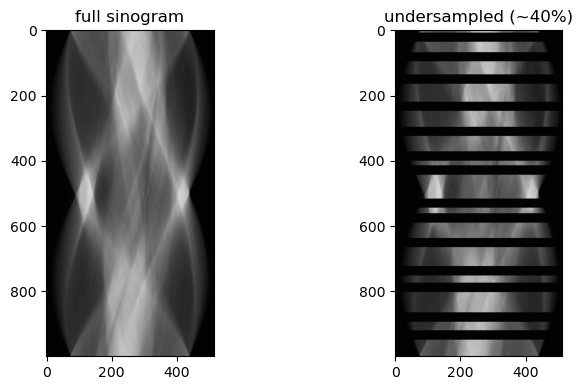

In [2]:
# 2) undersampling function + sample plot
def make_undersampling_mask(n_angles=1000, keep_frac=0.6, 
                            n_chunks_min=10, n_chunks_max=15,
                            jitter_fraction=0.3):
    """
    Create a boolean mask of length n_angles with ~keep_frac kept,
    in continuous random chunks (n_chunks chunks missing),
    with chunk-starts roughly evenly spaced but randomly perturbed.
    
    jitter_fraction controls how far (as a fraction of segment length)
    each start can move.
    """
    n_missing = int(n_angles * (1 - keep_frac))
    n_chunks = np.random.randint(n_chunks_min, n_chunks_max + 1)
    
    # Determine chunk sizes (sum to n_missing), jittered slightly:
    base = n_missing // n_chunks
    sizes = np.full(n_chunks, base)
    rem = n_missing - base * n_chunks
    sizes[:rem] += 1
    np.random.shuffle(sizes)
    
    mask = np.ones(n_angles, dtype=bool)
    
    # Evenly spaced segment start points for chunk placement:
    segment_length = n_angles / n_chunks
    for i, size in enumerate(sizes):
        # ideal start is i * segment_length
        ideal = int(i * segment_length)
        # allow jitter ± (segment_length * jitter_fraction)
        max_jit = int(segment_length * jitter_fraction)
        start = ideal + np.random.randint(-max_jit, max_jit + 1)
        start = np.clip(start, 0, n_angles - 1)
        end = min(n_angles, start + size)
        mask[start:end] = False
    
    return mask

# demo on one sinogram
dataset = get_standard_dataset("lodopab", impl="astra_cpu")
sino, gt = dataset.get_sample(0, part="train")
sino = sino.data.astype(np.float32)
mask = make_undersampling_mask()
undersino = sino.copy()
undersino[~mask, :] = 0.0

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sino, cmap="gray")
plt.title("full sinogram")
plt.subplot(1,2,2)
plt.imshow(undersino, cmap="gray")
plt.title("undersampled (~40%)")
plt.tight_layout()
plt.show()

In [3]:
# 3) dataset class with undersampling + two splits
fbp = get_reference_reconstructor('fbp', 'lodopab', impl='astra_cpu')

class CTDataset(Dataset):
    def __init__(self, dival_dataset, part='train', n_samples=1000,
                 keep_frac=0.6):
        self.dival_ds = dival_dataset
        self.part = part
        self.n = n_samples
        self.keep_frac = keep_frac

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        sino, gt = self.dival_ds.get_sample(idx, part=self.part)
        sino = sino.data.astype(np.float32)
        gt   = gt.data.astype(np.float32)
        # apply random undersampling mask
        mask = make_undersampling_mask(
            n_angles=sino.shape[0], keep_frac=self.keep_frac
        )
        usino = sino.copy()
        usino[~mask, :] = 0.0
        # PD input is [1,H,W]
        pd_in = torch.from_numpy(usino)[None]
        # PD target is the full sinogram
        pd_gt = torch.from_numpy(sino)[None]

        # ID target is gt image:
        id_gt = torch.from_numpy(gt)[None]

        return pd_in, pd_gt, id_gt

# create and split
full = CTDataset(dataset, part='train', n_samples=1000, keep_frac=0.6)
train_ds, val_ds = random_split(full, [900, 100])
test_ds = CTDataset(dataset, part='test', n_samples=100, keep_frac=0.6)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4)
test_loader  = DataLoader(test_ds,  batch_size=16)

In [4]:
# 4) CNN → output 4 channels for NIG parameters
class ConvINReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.norm = nn.InstanceNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class ResNetBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.in1   = nn.InstanceNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.in2   = nn.InstanceNorm2d(ch)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        return self.relu(out + x)

class UpConvINReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.norm = nn.InstanceNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.norm(self.up(x)))

class CNN_NIG(nn.Module):
    def __init__(self, in_ch=1, mid_feats=(64,128,256,512), bottleneck_ch=1024,
                 n_blocks=2):
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(
            ConvINReLU(in_ch,      mid_feats[0]),
            ConvINReLU(mid_feats[0], mid_feats[0]),
            ConvINReLU(mid_feats[0], mid_feats[0]),
        )
        self.enc2 = nn.Sequential(
            ConvINReLU(mid_feats[0], mid_feats[1]),
            ConvINReLU(mid_feats[1], mid_feats[1]),
        )
        self.enc3 = nn.Sequential(
            ConvINReLU(mid_feats[1], mid_feats[2]),
            ConvINReLU(mid_feats[2], mid_feats[2]),
        )
        self.enc4 = nn.Sequential(
            ConvINReLU(mid_feats[2], mid_feats[3]),
            ConvINReLU(mid_feats[3], mid_feats[3]),
        )
        self.pool = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_in  = ConvINReLU(mid_feats[3], bottleneck_ch)
        self.resblocks      = nn.Sequential(
            *[ResNetBlock(bottleneck_ch) for _ in range(n_blocks)]
        )
        self.bottleneck_out = ConvINReLU(bottleneck_ch, mid_feats[3])

        # decoder
        self.up4 = UpConvINReLU(mid_feats[3], mid_feats[3])
        self.dec4 = nn.Sequential(
            ConvINReLU(mid_feats[3]*2, mid_feats[3]),
            ConvINReLU(mid_feats[3],   mid_feats[3]),
        )
        self.up3 = UpConvINReLU(mid_feats[3], mid_feats[2])
        self.dec3 = nn.Sequential(
            ConvINReLU(mid_feats[2]*2, mid_feats[2]),
            ConvINReLU(mid_feats[2],   mid_feats[2]),
        )
        self.up2 = UpConvINReLU(mid_feats[2], mid_feats[1])
        self.dec2 = nn.Sequential(
            ConvINReLU(mid_feats[1]*2, mid_feats[1]),
            ConvINReLU(mid_feats[1],   mid_feats[1]),
        )
        self.up1 = UpConvINReLU(mid_feats[1], mid_feats[0])
        self.dec1 = nn.Sequential(
            ConvINReLU(mid_feats[0]*2, mid_feats[0]),
            ConvINReLU(mid_feats[0],   mid_feats[0]),
        )

        # final 1×1 to 4 channels (γ, ν, α, β)
        self.final = nn.Conv2d(mid_feats[0], 4, kernel_size=1)

    def forward(self, x):
        # handle odd width 513 → drop last column
        _,_,H,W = x.shape
        if W == 513:
            x = x[..., :-1]
        x_in = x

        # down
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # bottleneck
        b  = self.bottleneck_in(self.pool(e4))
        b  = self.resblocks(b)
        b  = self.bottleneck_out(b)

        # up
        d4 = self.dec4(torch.cat([self.up4(b),  e4], 1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))

        out = self.final(d1)  # shape B×4×H×(W-1)

        # pad back last column if needed
        if W == 513:
            last_col = out[..., -1:].clone()
            out = torch.cat([out, last_col], dim=-1)

        # split channels and apply softplus to ν, α, β
        gamma = out[:, 0:1]
        nu    = F.softplus(out[:, 1:2]) + 1.0
        alpha = F.softplus(out[:, 2:3])
        beta  = F.softplus(out[:, 3:4])

        return torch.cat([gamma, nu, alpha, beta], dim=1)

In [5]:
# 5) NIG loss + regularization
import torch.special as special

def nig_nll(y, gamma, nu, alpha, beta):
    """
    y:   true values [...,H,W]
    gamma,nu,alpha,beta: predictions, same shape
    returns per-pixel NLL
    """
    omega = 2.*beta*(1.+nu)
    # term1 = 0.5*log(pi/nu)
    term1 = 0.5*(torch.log(torch.tensor(np.pi, device=y.device)) - torch.log(nu))
    # term2 = -alpha*log(Omega)
    term2 = -alpha * torch.log(omega)
    # term3 = (alpha+0.5)*log((y-gamma)^2 * nu + Omega)
    term3 = (alpha + 0.5) * torch.log((y-gamma)**2 * nu + omega)
    # term4 = log Gamma(alpha) - log Gamma(alpha+0.5)
    term4 = special.gammaln(alpha) - special.gammaln(alpha + 0.5)
    return term1 + term2 + term3 + term4

def nig_reg(y, gamma, nu, alpha, beta):
    """regularizer: |y-gamma| * (2 nu + alpha)"""
    return torch.abs(y-gamma) * (2.*nu + alpha)

def nig_loss(pred, target, lam=1e-3):
    """
    pred: [B,4,H,W]: channels are [gamma, nu, alpha, beta]
    target: [B,1,H,W]
    """
    gamma, nu, alpha, beta = torch.chunk(pred,4,dim=1)
    y = target
    nll = nig_nll(y, gamma, nu, alpha, beta).mean()
    reg = nig_reg(y, gamma, nu, alpha, beta).mean()
    return nll + lam*reg, nll, reg

In [6]:
# 6) train PD model (fills sinogram)
PD_model = CNN_NIG(in_ch=1).to(device)
pd_optimizer = optim.Adam(PD_model.parameters(), lr=5e-4)

best_val = 1e9
for epoch in range(1, 11):
    PD_model.train()
    tot_loss = 0
    for pd_in, pd_gt, _ in tqdm(train_loader, desc=f"PD Epoch {epoch}"):
        pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
        pred = PD_model(pd_in)
        loss, nll, reg = nig_loss(pred, pd_gt, lam=1e-3)
        pd_optimizer.zero_grad(); loss.backward(); pd_optimizer.step()
        tot_loss += loss.item()
    print(f"  Train loss: {tot_loss/len(train_loader):.4f}")

    # validation
    PD_model.eval()
    with torch.no_grad():
        vloss = 0
        for pd_in, pd_gt, _ in val_loader:
            pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
            pred = PD_model(pd_in)
            loss,_,_ = nig_loss(pred, pd_gt, lam=1e-3)
            vloss += loss.item()
    vloss /= len(val_loader)
    print(f"  Val   loss: {vloss:.4f}")
    # checkpoint
    torch.save(PD_model.state_dict(), f"pd_epoch{epoch}.pth")
    if vloss < best_val:
        best_val = vloss
        torch.save(PD_model.state_dict(), "pd_best.pth")

PD Epoch 1:   0%|          | 0/57 [00:39<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 124 but got size 125 for tensor number 1 in the list.

In [ ]:
# Test the PD model
PD_model.load_state_dict(torch.load("pd_best.pth"))
PD_model.eval()
test_loss = 0
with torch.no_grad():
    for pd_in, pd_gt, _ in test_loader:
        pd_in, pd_gt = pd_in.to(device), pd_gt.to(device)
        pred = PD_model(pd_in)
        loss, _, _ = nig_loss(pred, pd_gt, lam=1e-3)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")

In [ ]:
# 7) train ID model: apply PD→FBP in loop
ID_model = CNN_NIG(in_ch=1, out_ch=4).to(device)
id_optimizer = optim.Adam(ID_model.parameters(), lr=5e-4)

for epoch in range(1, 11):
    ID_model.train()
    tot_loss = 0
    for pd_in, pd_gt, id_gt in tqdm(train_loader, desc=f"ID Epoch {epoch}"):
        # first fill sinogram with PD_model
        with torch.no_grad():
            pd_out = PD_model(pd_in.to(device))
            gamma,nu,alpha,beta = torch.chunk(pd_out,4,dim=1)
            sino_pred = gamma  # use mean prediction
            sino_pred = sino_pred.cpu().numpy().squeeze(1)
            # run FBP on each in batch
            fbp_batch = []
            for sino in sino_pred:
                rec = fbp.reconstruct(sino)
                fbp_batch.append(rec.data.astype(np.float32))
            fbp_batch = np.stack(fbp_batch)
            id_in_batch = torch.from_numpy(fbp_batch)[:,None].to(device)
        # now train ID_model to predict NIG on image domain
        pred = ID_model(id_in_batch)
        id_gt = id_gt.to(device)
        loss,_,_ = nig_loss(pred, id_gt, lam=1e-3)
        id_optimizer.zero_grad(); loss.backward(); id_optimizer.step()
        tot_loss += loss.item()
    print(f"  Train loss: {tot_loss/len(train_loader):.4f}")

    # val & checkpoint
    ID_model.eval()
    with torch.no_grad():
        vloss = 0
        for pd_in, pd_gt, id_gt in val_loader:
            # same pipeline
            pd_out = PD_model(pd_in.to(device))
            sino_pred = torch.chunk(pd_out,4,dim=1)[0].cpu().numpy().squeeze(1)
            fbp_batch = np.stack([fbp.reconstruct(s).data for s in sino_pred])
            id_in_batch = torch.from_numpy(fbp_batch).unsqueeze(1).to(device)
            pred = ID_model(id_in_batch)
            loss,_,_ = nig_loss(pred, id_gt.to(device), lam=1e-3)
            vloss += loss.item()
    vloss /= len(val_loader)
    print(f"  Val   loss: {vloss:.4f}")
    torch.save(ID_model.state_dict(), f"id_epoch{epoch}.pth")
    if vloss < best_val:
        best_val = vloss
        torch.save(ID_model.state_dict(), "id_best.pth")

In [ ]:
# Test the ID model
ID_model.load_state_dict(torch.load("id_best.pth"))
ID_model.eval()
test_loss = 0
with torch.no_grad():
    for pd_in, pd_gt, id_gt in test_loader:
        pd_out = PD_model(pd_in.to(device))
        sino_pred = torch.chunk(pd_out,4,dim=1)[0].cpu().numpy().squeeze(1)
        fbp_batch = np.stack([fbp.reconstruct(s).data for s in sino_pred])
        id_in_batch = torch.from_numpy(fbp_batch).unsqueeze(1).to(device)
        pred = ID_model(id_in_batch)
        loss, _, _ = nig_loss(pred, id_gt.to(device), lam=1e-3)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")